In [1]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from run_gradient_em_attack import run_attack

Instructions for updating:
non-resource variables are not supported in the long term


# Effect of epsilon on the different metrics

This section of the notebook reproduces Figure 2 of the original paper. We investigate the influence of epsilon on the different metrics (test error, statistical parity difference, equality of opportunity difference) and compare the results obtained using two different stopping criteria: average fairness and accuracy.

## Loading the pre-trained models
The next cell imports the required models, which have already been pre-trained. They are evaluated on the indicated dataset, and the results are stored.

*Note: this might take ~10 min.*

In [2]:
%%capture

results_eps_fairness = {}
results_eps_accuracy = {}

datasets = ["german", "compas", "drug"]
attacks  = ["IAF", "NRAA", "RAA", "Koh", "Solans"]
epsilon = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for dataset in datasets:

    # Each dictionary contains the datasets as keys. The value of these keys is another dictionary,
    # where they keys are the different attacks. They will store the values of the different metrics
    results_eps_fairness[dataset]   = {attack: {} for attack in attacks}
    results_eps_accuracy[dataset] = {attack: {} for attack in attacks}

    for attack in attacks:

        for eps in epsilon:

            # Retrieve results
            log_fairness   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Fairness",   eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Accuracy", eval_mode = True)

            # Store results using fairness as the stopping method
            results_eps_fairness[dataset][attack].setdefault("test_error", []).append(1 - log_fairness['test_acc'])
            results_eps_fairness[dataset][attack].setdefault("SPD", []).append(log_fairness['Parity'])
            results_eps_fairness[dataset][attack].setdefault("EOD", []).append(log_fairness['E0'])

            # Store results using Accuracy as the stopping method
            results_eps_accuracy[dataset][attack].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_eps_accuracy[dataset][attack].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_eps_accuracy[dataset][attack].setdefault("EOD", []).append(log_accuracy['E0'])


2022-01-31 17:27:09.789157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Fairness-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Fairness-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Fairness-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Accuracy-checkpoint
INFO:tensorflow:Restori

## Generating figure (Stopping Metric: Fairness)
Generating the plots to investigate the effect of epsilon when fairness is used as the stopping criteria.

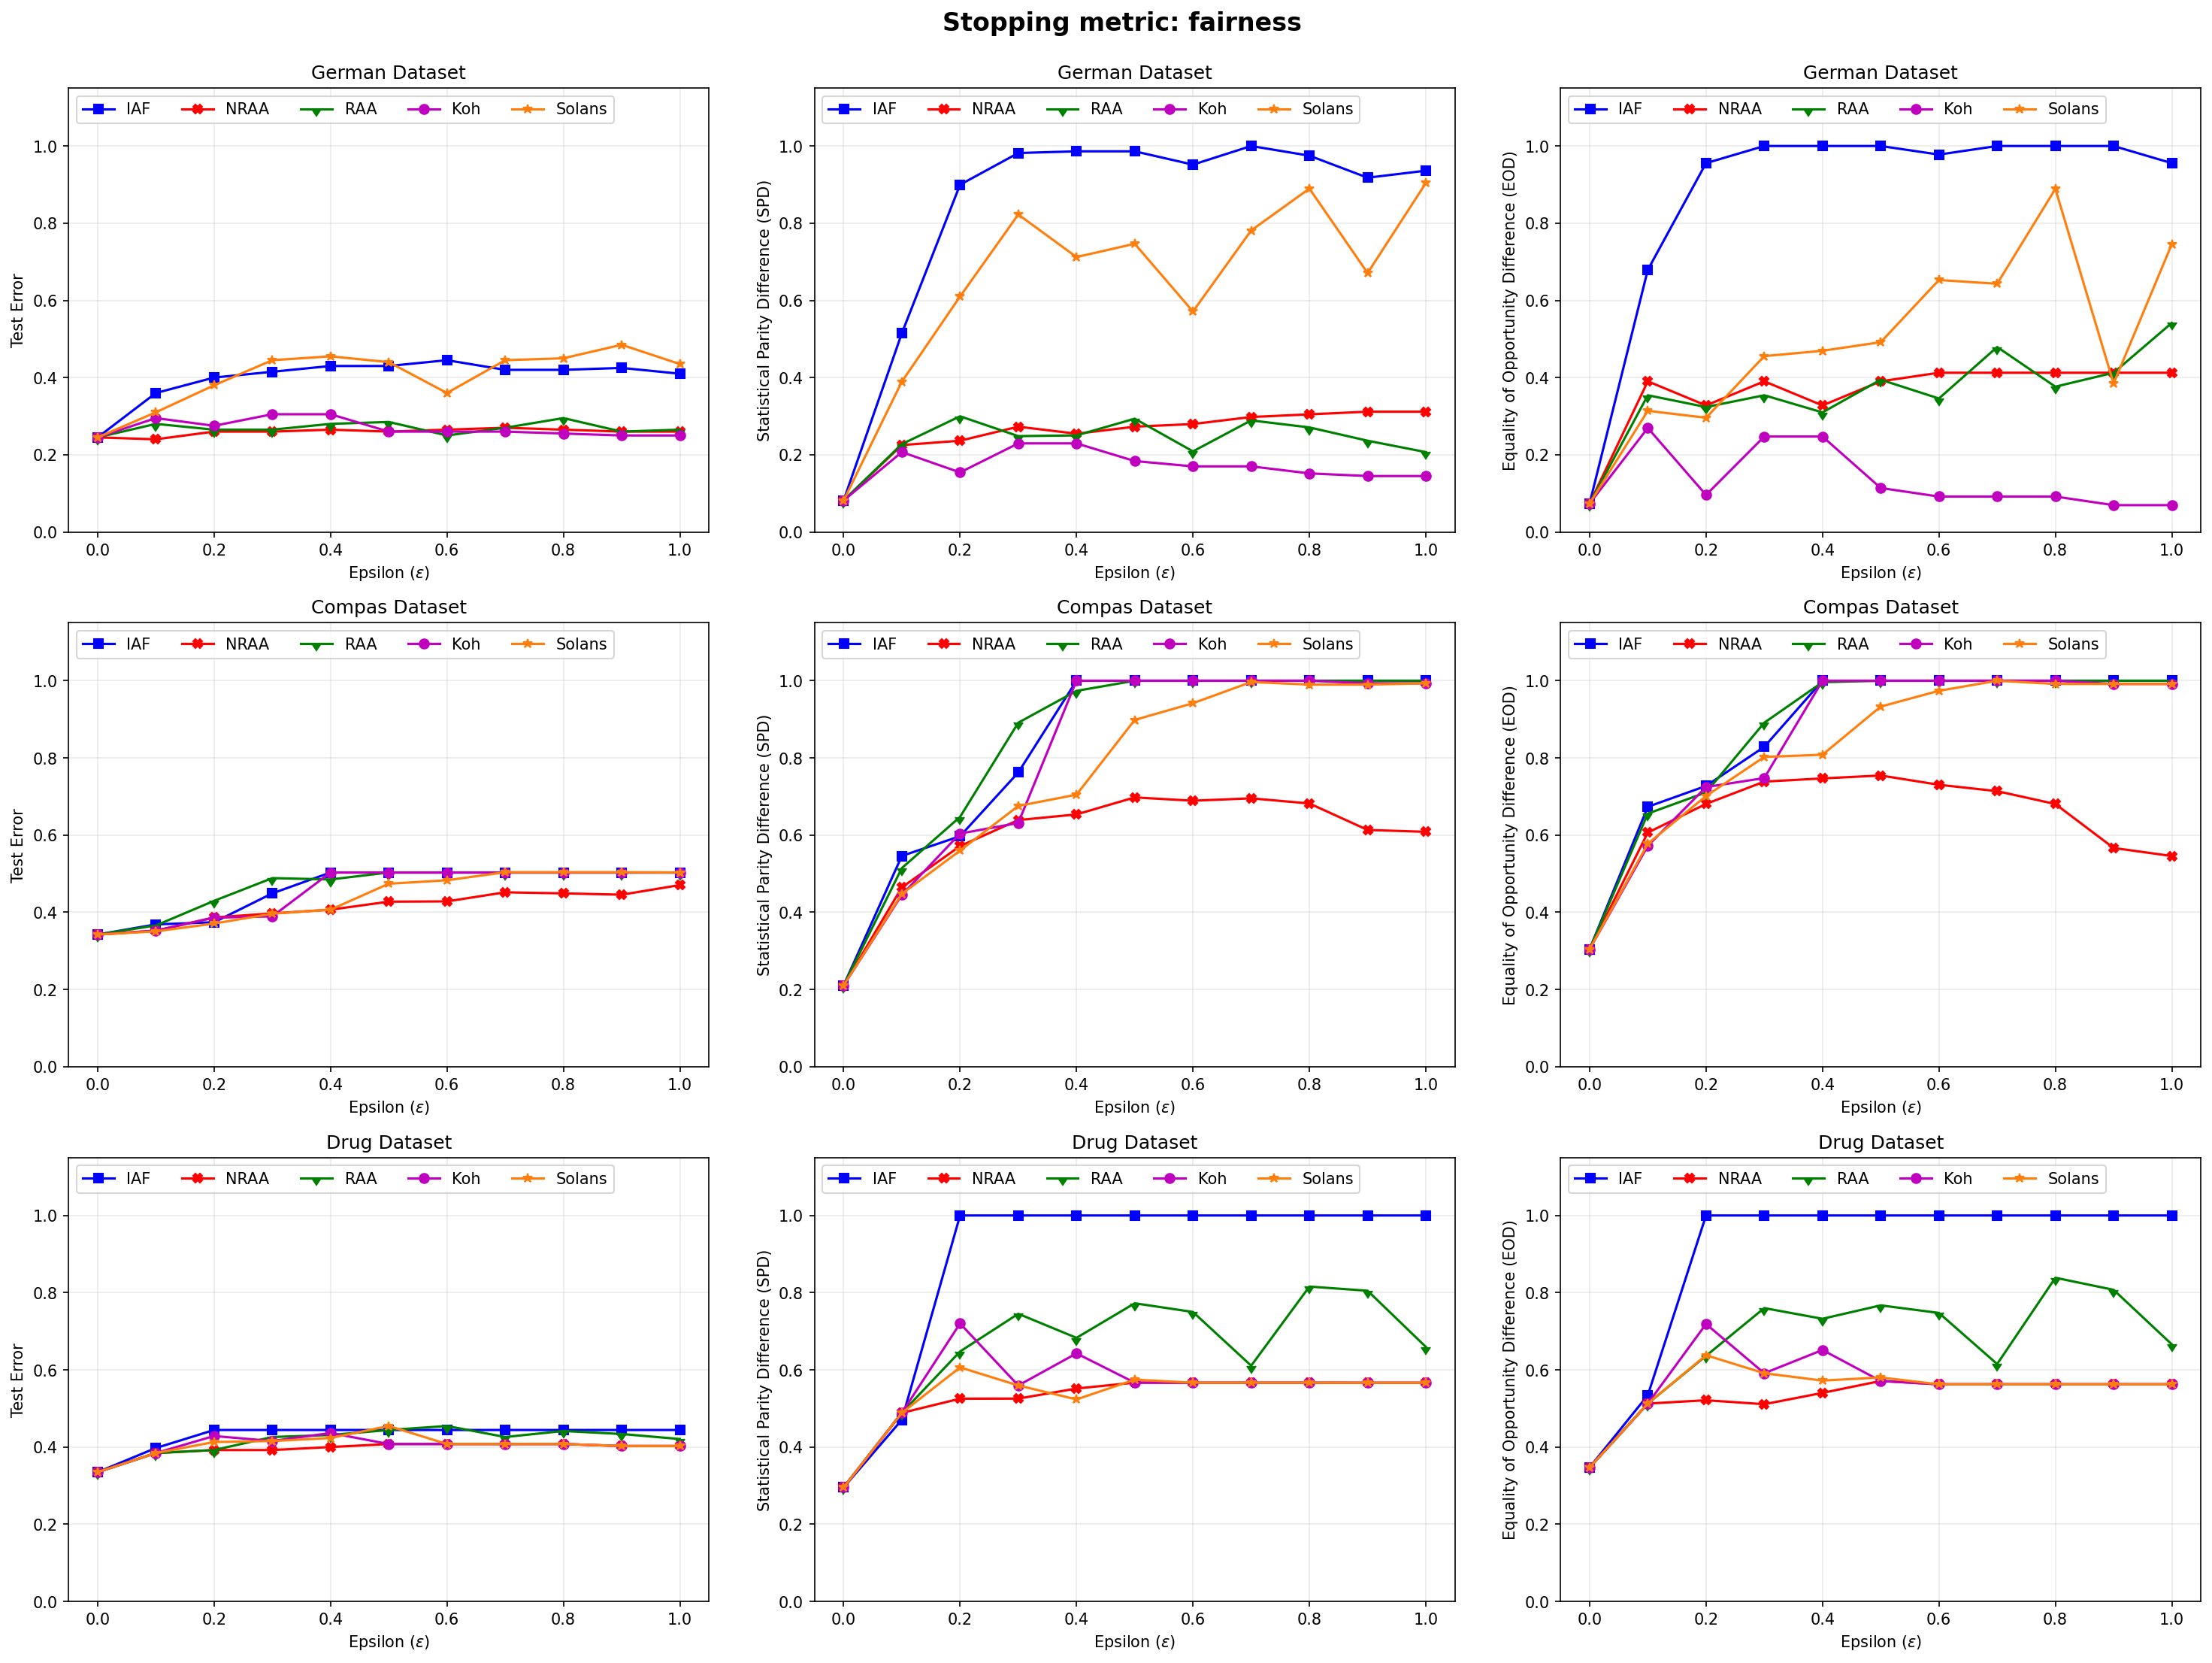

In [3]:
colors  = ['b', 'r', 'g', 'm', 'tab:orange']
markers = ['s', 'X', matplotlib.markers.CARETDOWNBASE, 'o', '*']

## Generating Figure 2 using FAIRNESS as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_eps_fairness[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=5, loc="upper left")
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: fairness\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)
Generating the plots to investigate the effect of epsilon when accuracy is used as the stopping criteria.

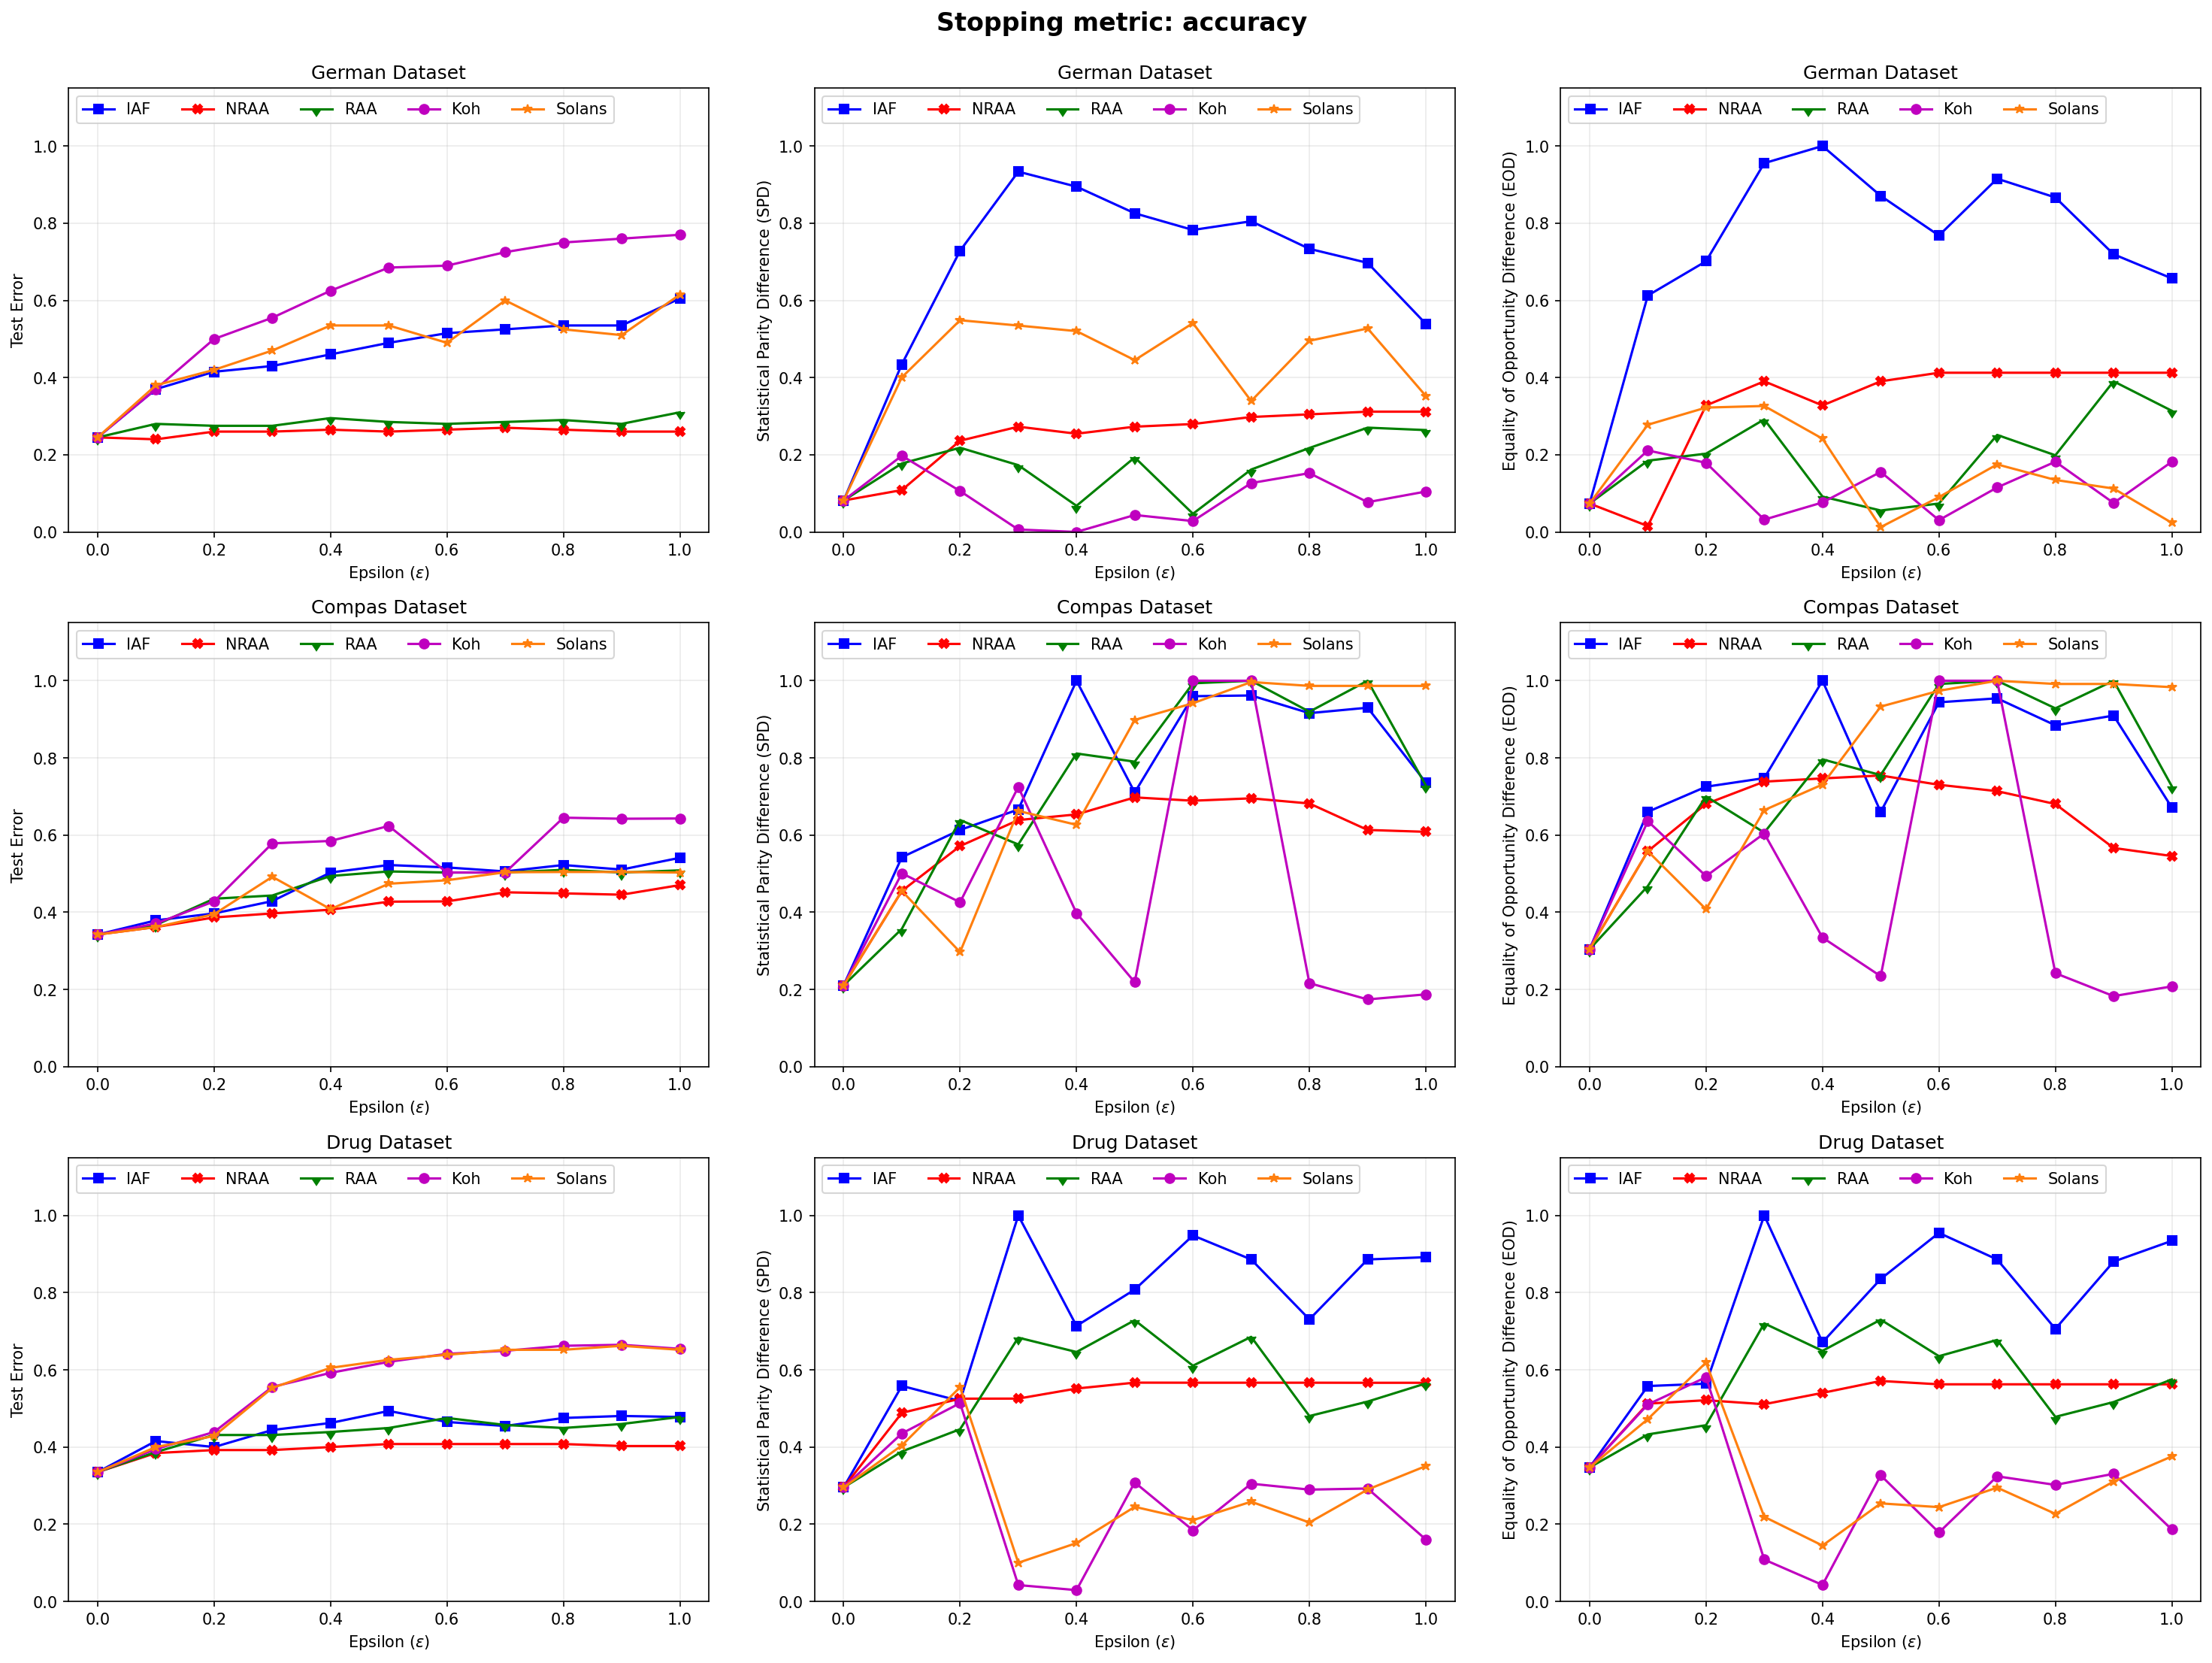

In [4]:
## Generating Figure 2 using ACCURACY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_eps_accuracy[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=5, loc="upper left")
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: accuracy\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Analysis of the results

Here we take an average over epsilon and make a table for every dataset. In every table, rows are attack methods, columns are different metrics, and the entries are the average metric over epsilon for that attack/metric pair. We report the average value obtained using both accuracy and fairness as the stopping criteria, to facilitate a comparative study.

In [5]:
for dataset in datasets:
    print('\n{:>45}'.format(dataset.upper() + ' DATASET: (Fairness/Accuracy)'))
    print("{:<10} {:>10} {:>15} {:>15}".format(" ", "Test Error", "SPD", "EOD"))
    for attack in attacks:
        avg_test_acc = np.mean(results_eps_accuracy[dataset][attack]['test_error'])
        avg_test_par = np.mean(results_eps_fairness[dataset][attack]['test_error'])
        avg_spd_acc = np.mean(results_eps_accuracy[dataset][attack]['SPD'])
        avg_spd_par = np.mean(results_eps_fairness[dataset][attack]['SPD'])
        avg_eod_acc = np.mean(results_eps_accuracy[dataset][attack]['EOD'])
        avg_eod_par = np.mean(results_eps_fairness[dataset][attack]['EOD'])
        
        print("{:<10} {:>10} {:>15} {:>15}".format(attack, 
            f"{avg_test_par:.2f}/{avg_test_acc:.2f}", 
            f"{avg_spd_par:.2f}/{avg_spd_acc:.2f}",
            f"{avg_eod_par:.2f}/{avg_eod_acc:.2f}"))
    


          GERMAN DATASET: (Fairness/Accuracy)
           Test Error             SPD             EOD
IAF         0.40/0.47       0.84/0.68       0.88/0.74
NRAA        0.26/0.26       0.26/0.25       0.36/0.33
RAA         0.27/0.28       0.24/0.17       0.36/0.19
Koh         0.27/0.61       0.17/0.08       0.13/0.12
Solans      0.40/0.48       0.65/0.44       0.49/0.16

          COMPAS DATASET: (Fairness/Accuracy)
           Test Error             SPD             EOD
IAF         0.46/0.47       0.83/0.75       0.87/0.77
NRAA        0.41/0.42       0.59/0.59       0.64/0.64
RAA         0.47/0.47       0.84/0.73       0.87/0.75
Koh         0.45/0.53       0.81/0.46       0.85/0.48
Solans      0.44/0.45       0.76/0.73       0.83/0.78

            DRUG DATASET: (Fairness/Accuracy)
           Test Error             SPD             EOD
IAF         0.43/0.45       0.89/0.75       0.90/0.76
NRAA        0.39/0.39       0.53/0.53       0.53/0.53
RAA         0.42/0.44       0.66/0.55       0.68/

# Effect of lambda on the different metrics

This section of the notebook reproduces Figure 3 of the original paper. We investigate the influence of lambda on the different metrics (test error, statistical parity difference, equality of opportunity difference) for different epsilons. Again, we compare the results obtained using two different stopping criteria: fairness and accuracy.

## Loading the pre-trained models
The next cell imports the required models, which have already been pre-trained. They are evaluated on the indicated dataset, and the results are stored.

*Note: this might take up to ~15 min.*

In [6]:
%%capture

results_lamb_fairness = {}
results_lamb_accuracy = {}

datasets = ["german", "compas", "drug"]
lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
epsilons = [0.0, 0.1, 0.5, 1.0]

for dataset in datasets:

    # Each dictionary contains epsilon as keys
    results_lamb_fairness[dataset]   = {epsilon: {} for epsilon in epsilons}
    results_lamb_accuracy[dataset] = {epsilon: {} for epsilon in epsilons}

    for eps in epsilons:

        for lamb in lambdas:

            # Retrieve results
            log_fairness   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Fairness",   eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Accuracy", eval_mode = True)

            # Store results using Fairness as the stopping method
            results_lamb_fairness[dataset][eps].setdefault("test_error", []).append(1 - log_fairness['test_acc'])
            results_lamb_fairness[dataset][eps].setdefault("SPD", []).append(log_fairness['Parity'])
            results_lamb_fairness[dataset][eps].setdefault("EOD", []).append(log_fairness['E0'])

            # Store results using Accuracy as the stopping method
            results_lamb_accuracy[dataset][eps].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_lamb_accuracy[dataset][eps].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_lamb_accuracy[dataset][eps].setdefault("EOD", []).append(log_accuracy['E0'])


INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tenso

## Generating figure (Stopping Metric: Fairness)
Generating the plots to investigate the effect of lambda when fairness is used as the stopping criteria.

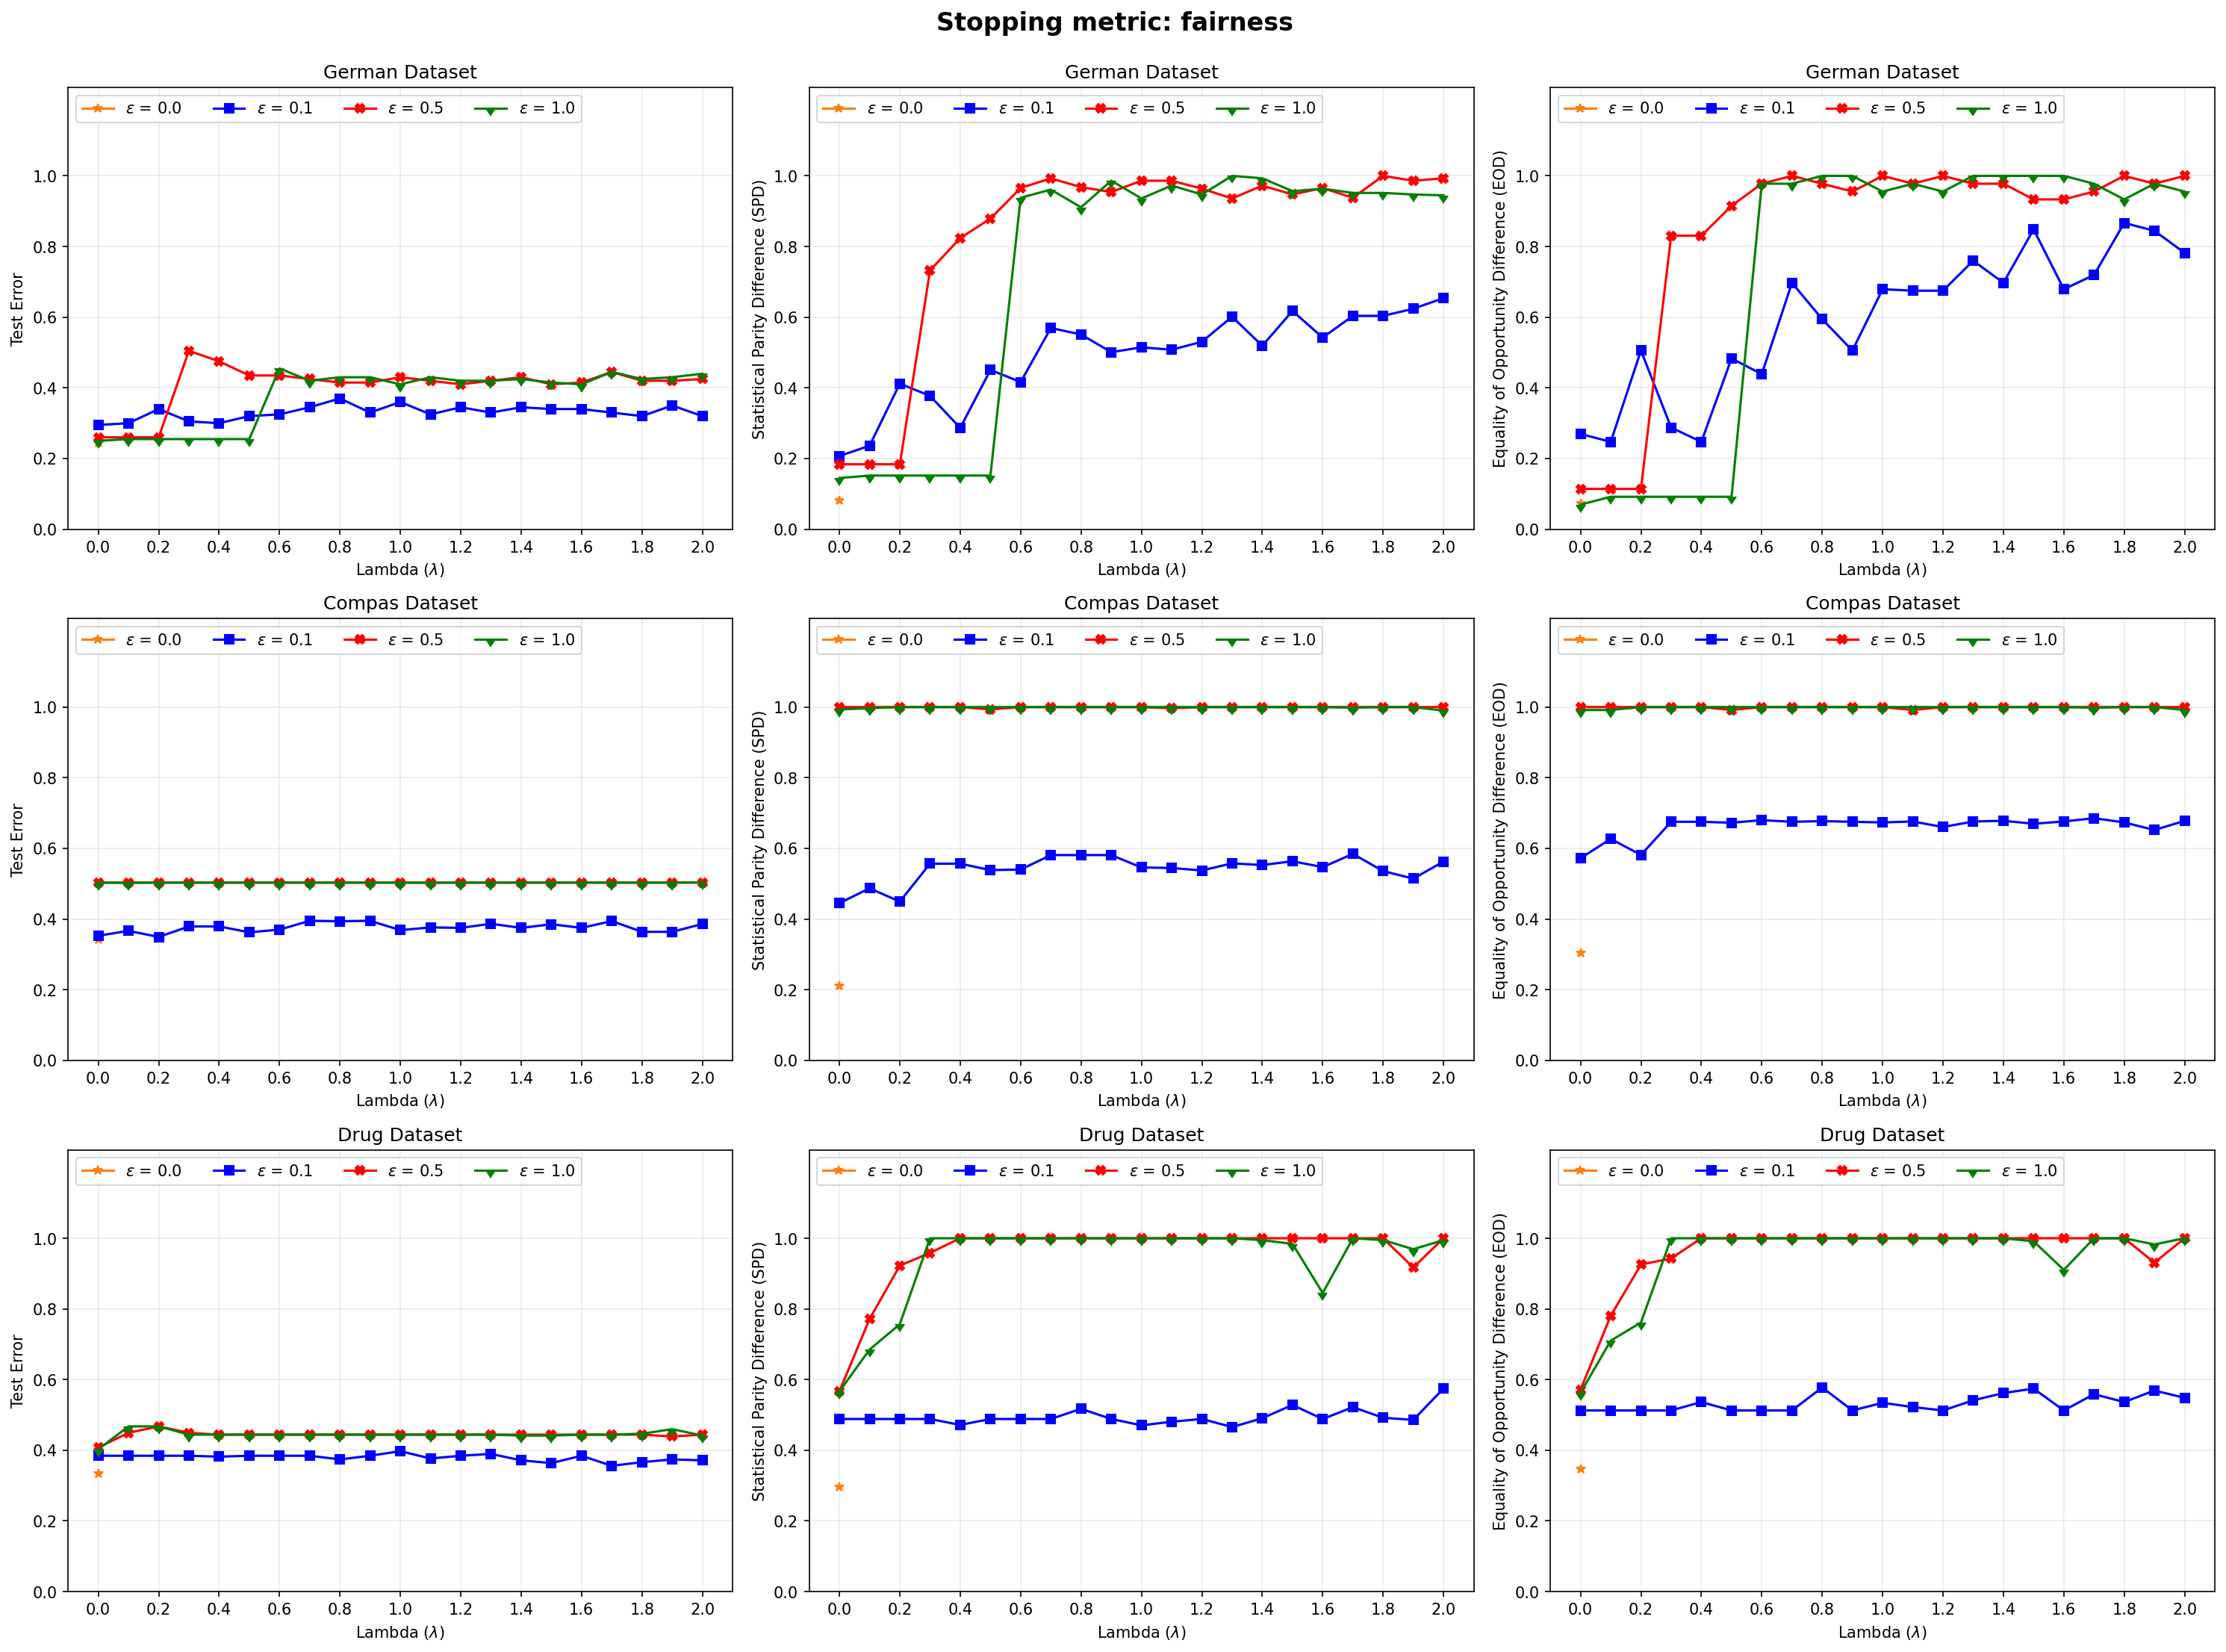

In [7]:
colors  = ['tab:orange', 'b', 'r', 'g']
markers = ['*', 's', 'X', matplotlib.markers.CARETDOWNBASE]

## Generating Figure 2 using fairness as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for eps, c, m in zip(epsilons, colors, markers):
            if eps == 0:
                axs[row, col].plot(lambdas[0], results_lamb_fairness[dataset][eps][metric][0], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            else:
                axs[row, col].plot(lambdas, results_lamb_fairness[dataset][eps][metric], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            axs[row, col].legend(loc='upper left', ncol=4)
            axs[row, col].set_ylim([0, 1.25])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Lambda ($\lambda$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: fairness\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)
Generating the plots to investigate the effect of lambda when accuracy is used as the stopping criteria.

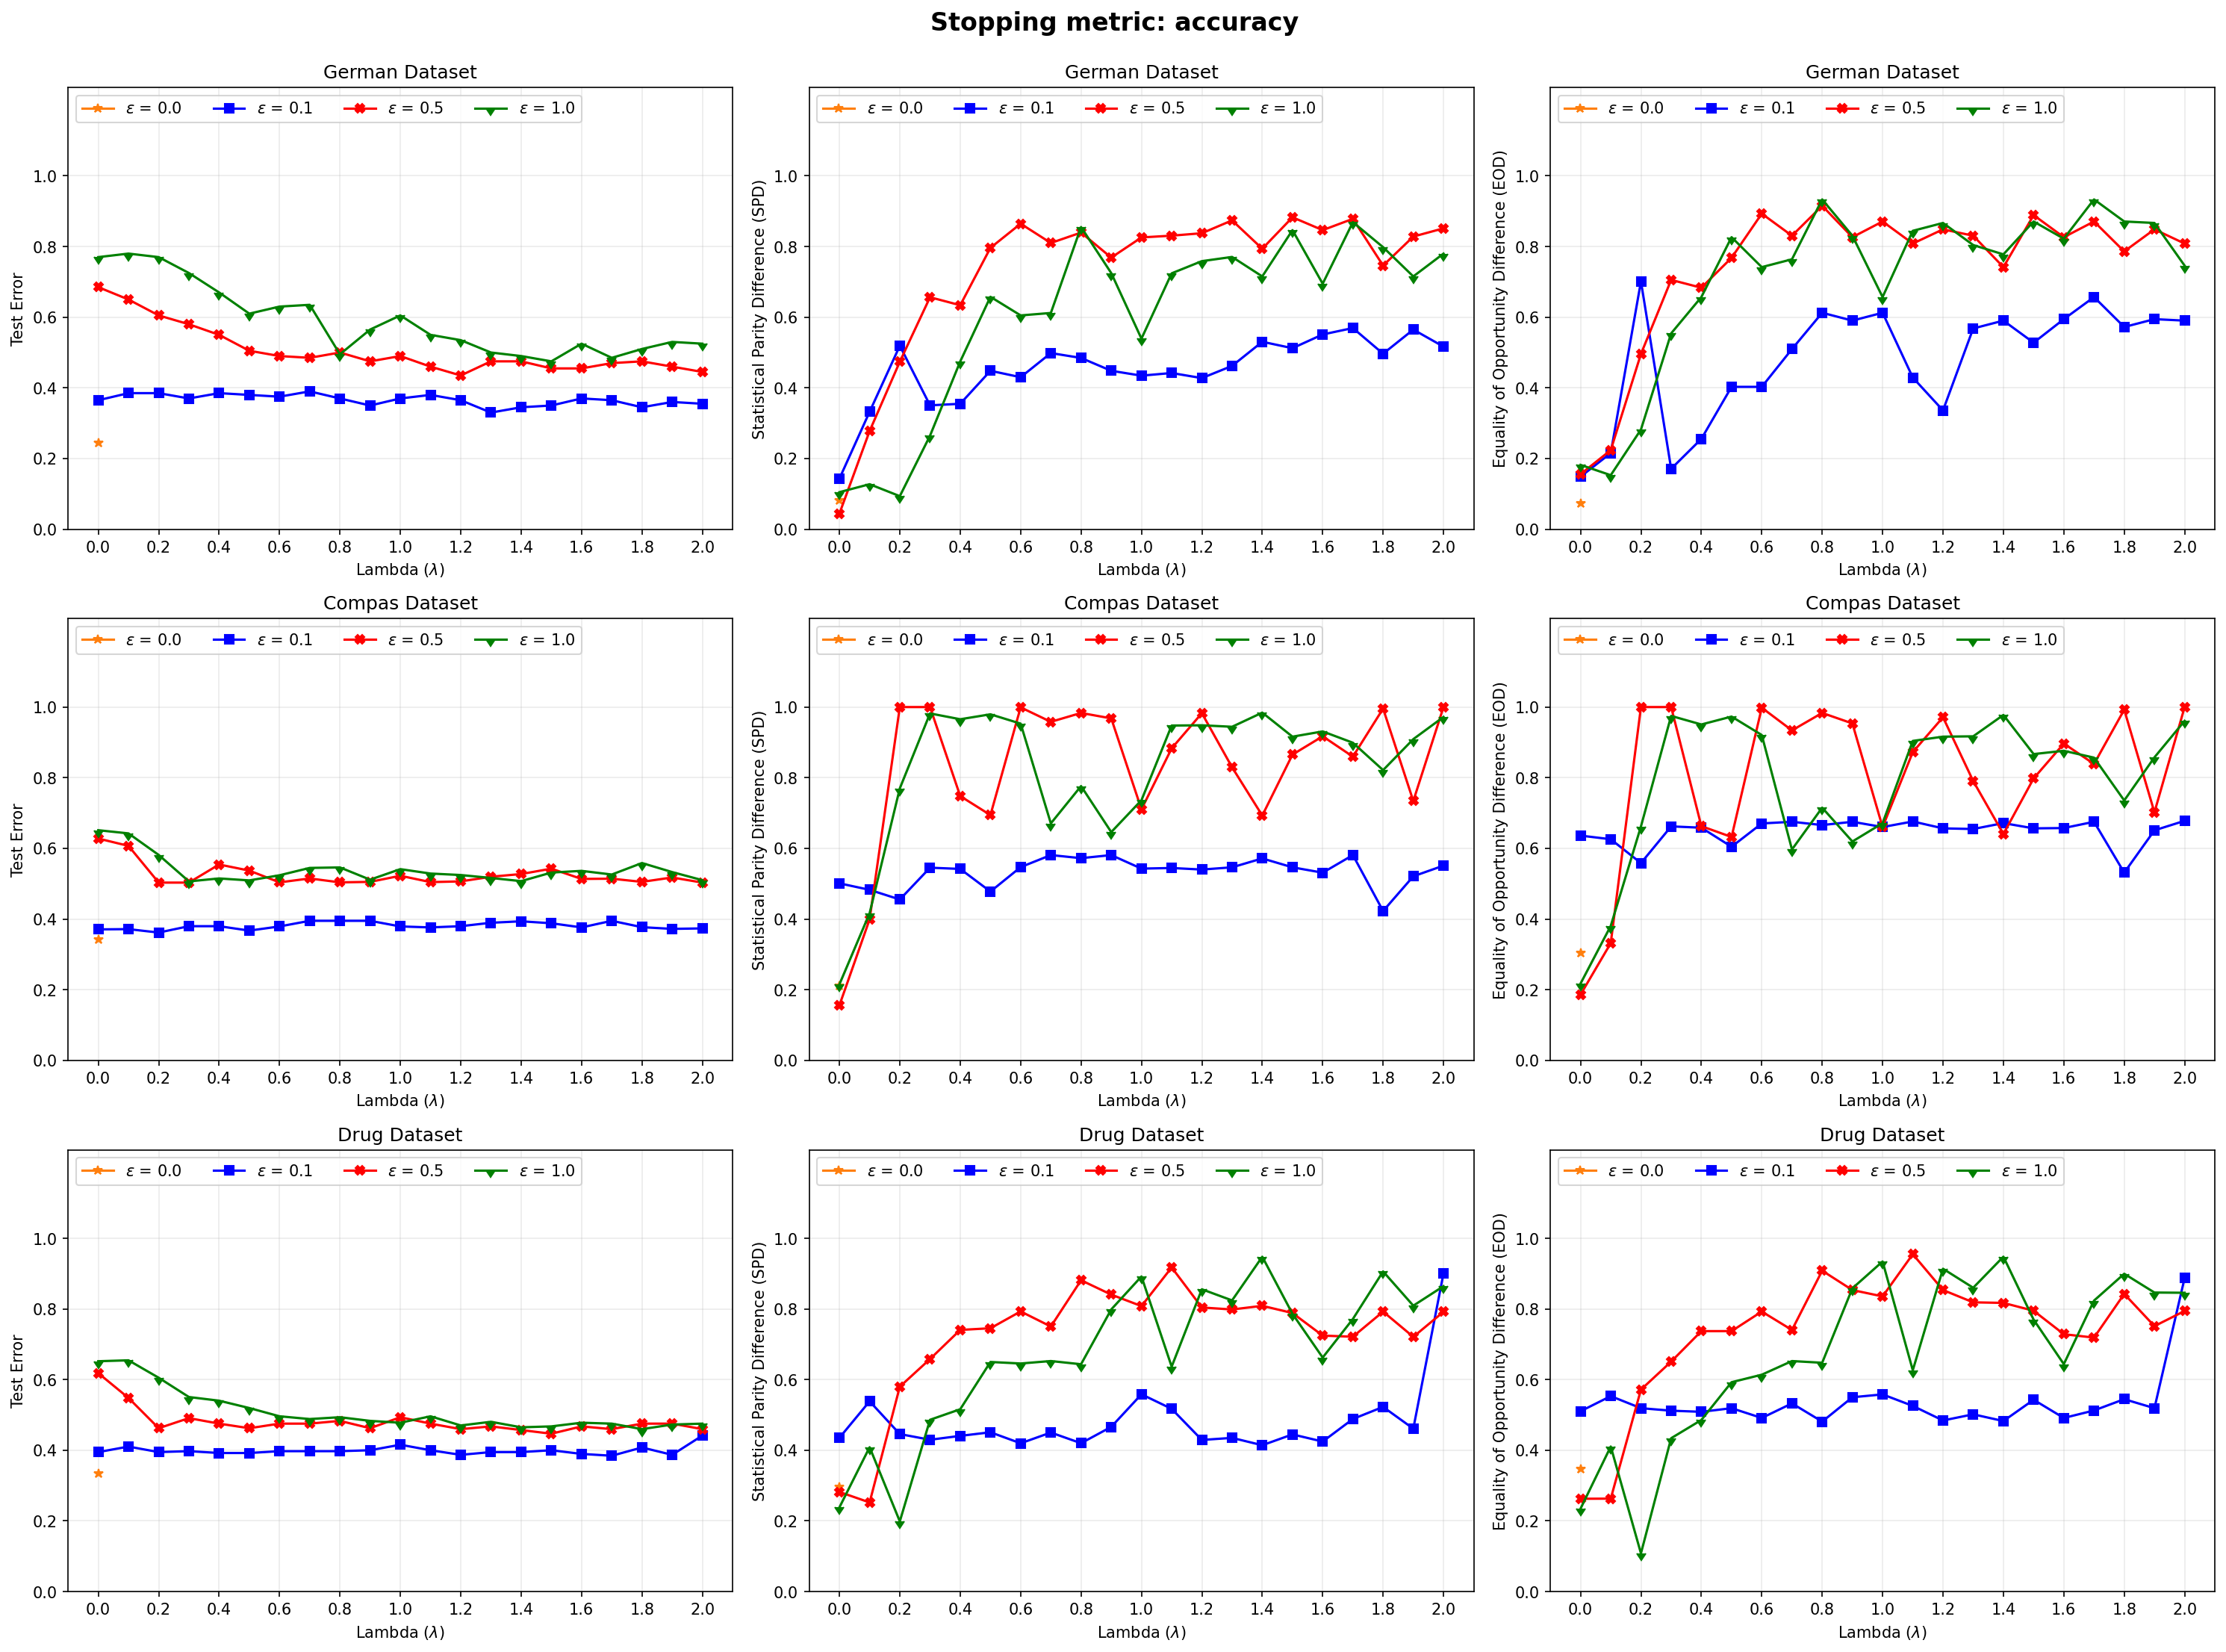

In [8]:
colors  = ['tab:orange', 'b', 'r', 'g']
markers = ['*', 's', 'X', matplotlib.markers.CARETDOWNBASE]

## Generating Figure 2 using ACCURACY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for eps, c, m in zip(epsilons, colors, markers):
            if eps == 0:
                axs[row, col].plot(lambdas[0], results_lamb_accuracy[dataset][eps][metric][0], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            else:
                axs[row, col].plot(lambdas, results_lamb_accuracy[dataset][eps][metric], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            axs[row, col].legend(loc='upper left', ncol=4)
            axs[row, col].set_ylim([0, 1.25])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Lambda ($\lambda$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: accuracy\n', fontsize=16, fontweight='bold')
fig.tight_layout()

# Study of the accuracy-fairness tradeoff 
In this section we present results that extend Mehrabi et al's work. We study the trade-off between accuracy and fairness introduced by the term lambda, for representative attacks and datasets.

## Load models

In [9]:
main_folder = 'output/'
german_json_folder = os.path.join(main_folder, 'german', 'influence_data')
compas_json_folder = os.path.join(main_folder, 'compas', 'influence_data')
drug_json_folder   = os.path.join(main_folder, 'drug',   'influence_data')

# Accuracy/Fairness tradeoff depending on the epoch, for Accuracy based stopper, Solans attack, COMPAS dataset
f_drug_iaf = open(os.path.join(drug_json_folder, 'drug_IAF_0.5_1.0_Accuracy-checkpoint.json'))
drug_iaf = json.load(f_drug_iaf)

# Accuracy/Fairness tradeoff depending on the epoch, for Fairness based stopper, Solans attack, COMPAS dataset
f_german_solans = open(os.path.join(german_json_folder, 'german_Solans_0.5_1.0_Fairness-checkpoint.json'))
german_solans = json.load(f_german_solans)

## Generate plots

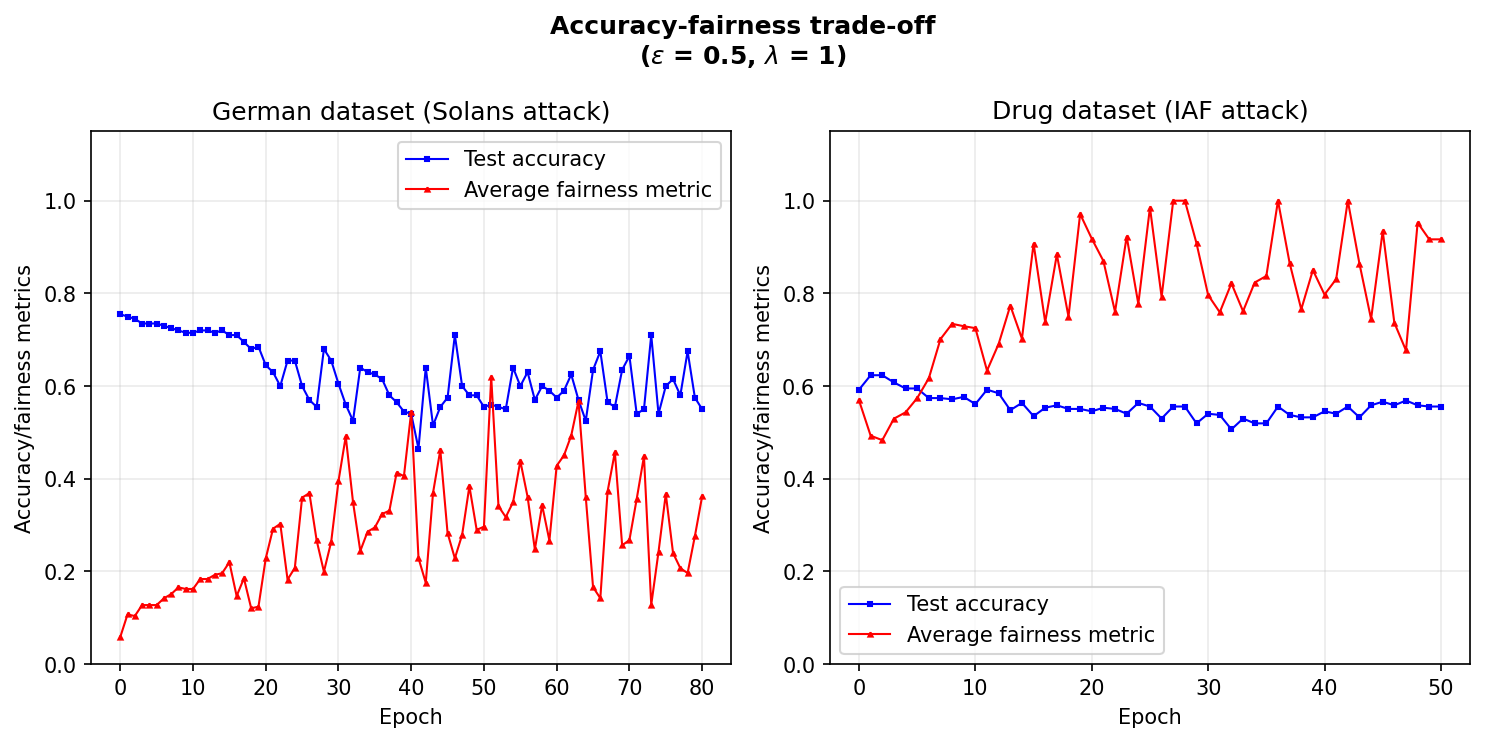

In [10]:
# First plot
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=150)
axs[0].set_title('German dataset (Solans attack)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy/fairness metrics')
axs[0].plot(german_solans['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[0].plot(german_solans['Average_Parities'], label='Average fairness metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[0].set_ylim([0, 1.15])
axs[0].grid(alpha=0.25)
axs[0].legend()

# Second plot
axs[1].set_title('Drug dataset (IAF attack)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy/fairness metrics')
axs[1].plot(drug_iaf['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[1].plot(drug_iaf['Average_Parities'], label='Average fairness metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[1].set_ylim([0, 1.15])
axs[1].grid(alpha=0.25)
axs[1].legend()

fig.suptitle('Accuracy-fairness trade-off\n($\epsilon$ = 0.5, $\lambda$ = 1)', fontweight = 'bold')
fig.tight_layout()

## Analysis
At the epoch with minimal accuracy, what is the value of the average fairness? What can be the actual maximal value of the average fairness?

In [11]:
# -- Get relevant stats of the run with the german dataset
min_acc_idx_german = int(np.where(german_solans['Accuracies']==np.min(german_solans['Accuracies']))[0])
fairness_at_min_acc_german = german_solans['Average_Parities'][min_acc_idx_german]
# -- Get relevant stats of the run with the compas dataset
min_acc_idx_drug = int(np.where(drug_iaf['Accuracies']==np.min(drug_iaf['Accuracies']))[0])
fairness_at_min_acc_drug = drug_iaf['Average_Parities'][min_acc_idx_drug]

# Print info
print("{:<48} {:<18} {:<16}".format(" ", "German (Solans)", "Compas (IAF)"))
print("{:<48} {:<18.3f} {:<16.3f}".format("Minimum accuracy:", np.min(german_solans['Accuracies']), np.min(drug_iaf['Accuracies'])))
print("{:<48} {:<18.3f} {:<16.3f}".format("Avg fairness at the point of minimum accuracy:", fairness_at_min_acc_german, fairness_at_min_acc_drug))
print("{:<48} {:<18.3f} {:<16.3f}".format("Actual maximal avg fairness:", np.max(german_solans['Average_Parities']), np.max(drug_iaf['Average_Parities'])))


                                                 German (Solans)    Compas (IAF)    
Minimum accuracy:                                0.465              0.506           
Avg fairness at the point of minimum accuracy:   0.229              0.822           
Actual maximal avg fairness:                     0.619              1.000           
